In [3]:
import sqlalchemy as sa
import pandas as pd

import json
import logging
import requests

from sqlalchemy import inspect
from sqlalchemy.sql import text

In [4]:
def get_database_engine(environment: str):
    if environment == 'production':
        url = 'https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json'
        params = requests.get(url).json()['params']
        engine = sa.create_engine(
            f"postgresql+psycopg2://{params['user']}:{params['password']}@{params['host']}/{params['dbname']}"
        )
    
    elif environment == 'staging':
        with open('alerceread_db_staging.json', 'r', encoding='utf-8') as f:
            params = json.load(f)
        engine = sa.create_engine(
            f"postgresql+psycopg2://{params['user']}:{params['password']}@{params['host']}:{params['port']}/{params['dbname']}"
        )
    else:
        raise ValueError(f'Environment "{environment}" not defined')
        
    inspector = inspect(engine)
    tables = inspector.get_table_names()
    print('Available Tables:\n', tables)
    return engine

In [5]:
ENVIRONMENT = "production"
engine = get_database_engine(environment=ENVIRONMENT)
engine.begin()

Available Tables:
 ['outlier', 'feature_version', 'gaia_ztf', 'alembic_version', 'ss_ztf', 'allwise', 'non_detection', 'step', 'taxonomy', 'feature', 'pipeline', 'lc_classifier_top', 'lc_classifier_periodic', 'lc_classifier_transient', 'magstat', 'lc_classifier', 'stamp_classifier', 'dataquality', 'object', 'lc_classifier_stochastic', 'lc_classifier_beta', 'forced_photometry', 'lc_classifier_bhrf_forced_phot_childs', 'reference', 'ps1_ztf', 'xmatch', 'detection', 'probability']


In [6]:
import glob

oids = [oid.split('/')[-1].split('.')[0] for oid in glob.glob('db_production/data/*') if oid.find('detections_log') == -1]
#oids = [oids[0]]
oids = [f"'{oid}'" for oid in oids]
oids

["'ZTF18aczrcpa'",
 "'ZTF17aaaiebm'",
 "'ZTF19aaerbsi'",
 "'ZTF18aclhyio'",
 "'ZTF19aaksblm'",
 "'ZTF19aaerfal'",
 "'ZTF17aaagsek'",
 "'ZTF18adfkawo'",
 "'ZTF17aaaidli'",
 "'ZTF17aaanptr'",
 "'ZTF17aablkjm'",
 "'ZTF20aaekbab'",
 "'ZTF19aaaktta'",
 "'ZTF18acgrywn'",
 "'ZTF17aaanwzg'",
 "'ZTF18accmzfi'",
 "'ZTF18aczuhzw'",
 "'ZTF18acubkiz'",
 "'ZTF18acztbwz'",
 "'ZTF17aaaidon'",
 "'ZTF19aaljmqd'",
 "'ZTF18acruncb'",
 "'ZTF20acvtqmd'",
 "'ZTF19aaerhgp'",
 "'ZTF18acwwbsg'",
 "'ZTF19aaercvx'",
 "'ZTF19aaerdxm'",
 "'ZTF17aabwlhw'",
 "'ZTF20aaibsiu'",
 "'ZTF19aaailqv'",
 "'ZTF19aaerfrz'",
 "'ZTF19aaljmmw'",
 "'ZTF19aapikgh'",
 "'ZTF19aaakylj'",
 "'ZTF17aacyjcj'",
 "'ZTF20abyosui'",
 "'ZTF21acoiozz'",
 "'ZTF19aaerhhk'",
 "'ZTF19aaererg'",
 "'ZTF19aaerfrd'",
 "'ZTF19aaakuwy'",
 "'ZTF18acnnwya'",
 "'ZTF19aaerbyb'",
 "'ZTF19aclhksr'",
 "'ZTF18adayhpt'",
 "'ZTF19aadlbyq'",
 "'ZTF18aczrhqa'",
 "'ZTF19aaerbcx'",
 "'ZTF17aaaitlx'",
 "'ZTF18achyyjr'",
 "'ZTF19acxhzcj'",
 "'ZTF19aaakukj'",
 "'ZTF20aaca

In [ ]:
out_message = {
    "oid": oid,
    "candid": candid,
    "detections": message["detections"],
    "non_detections": message["non_detections"],
    "xmatches": message["xmatches"],
    "features": features_for_oid,
    "reference": reference,
}
output_messages.append(out_message)

In [5]:
def preprocess_features_from_db(features: pd.DataFrame) -> pd.DataFrame:
    """features come from db in column format"""
    def fid_map(v):
        if v == 1:
            return "_1"  #'g'
        if v == 2:
            return "_2"  #'r'
        if v == 0:
            return ""
        if v == 12:
            return "_12"

    def normalize_name(v):
        return str(v).replace("-", "_").replace('/', '_')

    features_ = features.copy()
    features_["fid_name"] = features_["fid"].apply(lambda x: fid_map(x))
    features_["name"] = features_["name"] + features_["fid_name"]
    features_["name"] = features_["name"].apply(lambda x: normalize_name(x))
    features_ = features_[["oid", "name", "value"]]
    features_ = features_.pivot_table(
        index="oid", columns="name", values="value", aggfunc="first", dropna=False
    )

    return features_

In [7]:
# GET FEATURES
query_features = f"""
                SELECT * FROM feature as f 
                WHERE f.oid in ({','.join(oids)}) and f.version = '27.5.0';
                """

features = pd.read_sql_query(query_features, con=engine)
features

,oid,name,value,fid,version
0,ZTF17aaagsek,Amplitude,5.968180e-01,1,27.5.0
1,ZTF17aaagsek,Amplitude,6.442189e-01,2,27.5.0
2,ZTF17aaagsek,AndersonDarling,1.000000e+00,1,27.5.0
3,ZTF17aaagsek,AndersonDarling,1.000000e+00,2,27.5.0
4,ZTF17aaagsek,Autocor_length,7.000000e+00,1,27.5.0
...,...,...,...,...,...
20621,ZTF23abthyqt,ulens_u0,1.932796e-11,1,27.5.0
20622,ZTF23abthyqt,ulens_u0,3.141843e-11,2,27.5.0
20623,ZTF23abthyqt,W1-W2,-4.500008e-02,0,27.5.0
20624,ZTF23abthyqt,W2-W3,-3.000002e-01,0,27.5.0


In [8]:
features_ale = features.copy()
features_ale['fid'] = features_ale['fid'].map({1: 'g', 2: 'r', 12: 'g,r', 0: None})
features_ale['name'] = features_ale['name'].str.replace('/', '_')
features_ale = features_ale.drop_duplicates(subset=["oid", "name", "fid"])
features_ale

,oid,name,value,fid,version
0,ZTF17aaagsek,Amplitude,5.968180e-01,g,27.5.0
1,ZTF17aaagsek,Amplitude,6.442189e-01,r,27.5.0
2,ZTF17aaagsek,AndersonDarling,1.000000e+00,g,27.5.0
3,ZTF17aaagsek,AndersonDarling,1.000000e+00,r,27.5.0
4,ZTF17aaagsek,Autocor_length,7.000000e+00,g,27.5.0
...,...,...,...,...,...
20621,ZTF23abthyqt,ulens_u0,1.932796e-11,g,27.5.0
20622,ZTF23abthyqt,ulens_u0,3.141843e-11,r,27.5.0
20623,ZTF23abthyqt,W1-W2,-4.500008e-02,None,27.5.0
20624,ZTF23abthyqt,W2-W3,-3.000002e-01,None,27.5.0


In [ ]:
features_for_oid = dict(
    zip(feature_names, ao_features["value"].astype(np.double))
)
for key in features_for_oid.keys():
    features_for_oid[key] = (
        None if np.isnan(features_for_oid[key]) else features_for_oid[key]
    )

In [ ]:
def all_features_from_astro_objects(astro_objects: List[AstroObject]) -> pd.DataFrame:
    first_object = astro_objects[0]
    features = first_object.features.drop_duplicates(subset=["name", "fid"])
    features = features.set_index(["name", "fid"])
    indexes = features.index.values

    feature_list = []
    oids = []
    for astro_object in astro_objects:
        features = astro_object.features.drop_duplicates(subset=["name", "fid"])
        features = features.set_index(["name", "fid"])
        feature_list.append(features.loc[indexes]["value"].values)

        oid = query_ao_table(astro_object.metadata, "oid")
        oids.append(oid)

    df = pd.DataFrame(
        data=np.stack(feature_list, axis=0),
        index=oids,
        columns=["_".join([str(i) for i in pair]) for pair in indexes],
    )
    df.index.name = "oid"
    return df

In [14]:
features = preprocess_features_from_db(features)
features

name,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,ulens_fs_1,ulens_fs_2,ulens_mag0_1,ulens_mag0_2,ulens_t0_1,ulens_t0_2,ulens_tE_1,ulens_tE_2,ulens_u0_1,ulens_u0_2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaagyhh,0.316409,0.309808,1.000000,1.000000,1.0,1.0,0.327044,0.365517,0.0,0.0,...,1.000000,1.000000,15.083394,14.594233,1495.181488,800.321947,13.715539,4.090437,9.357354e-01,9.509671e-01
ZTF17aaahinf,0.600024,0.432720,1.000000,1.000000,1.0,1.0,0.487500,0.388350,0.0,0.0,...,0.531400,1.000000,16.578478,16.394721,289.085667,694.848322,0.136763,0.999667,1.167508e-01,8.780373e-10
ZTF17aaarvek,0.230988,0.218993,1.000000,1.000000,1.0,1.0,0.405034,0.454321,0.0,0.0,...,0.277149,0.999995,16.731932,15.670571,1983.684952,1233.766632,0.002665,18.471085,3.196195e-02,2.678936e-10
ZTF17aabuyoa,0.619639,0.441053,1.000000,1.000000,1.0,1.0,0.425837,0.435567,0.0,0.0,...,0.000253,0.517568,18.165204,17.277786,2198.928737,2050.102694,6.864093,0.995069,2.843445e-04,6.724024e-02
ZTF17aabvxoe,0.234099,0.221737,1.000000,1.000000,1.0,1.0,0.352941,0.419355,0.0,0.0,...,0.083431,1.000000,14.960351,14.419074,225.741039,831.207850,211.600441,3.039176,7.386241e-06,8.577218e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF22abpujoh,0.089690,0.120265,0.381993,0.939787,1.0,1.0,0.309524,0.298507,0.0,0.0,...,0.999999,0.060807,18.697553,18.530954,610.813649,877.096151,66.751735,0.002594,3.133226e-04,5.336261e-01
ZTF22abybtmt,NaN,0.064967,NaN,0.723670,NaN,1.0,NaN,0.235294,NaN,0.0,...,1.000000,1.000000,19.058006,17.620424,760.800505,816.011074,0.482324,2.119831,2.884365e-07,5.549644e-07
ZTF23aabness,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,1.000000,14.296145,14.027384,655.449678,698.418726,59.631588,61.964096,1.480142e+00,1.062567e+00


In [11]:
len(features.index.unique())

99

In [22]:
from alerce_classifiers.base.dto import InputDTO
from alerce_classifiers.base._types import *

input_dto = InputDTO(
        Detections(pd.DataFrame()),
        NonDetections(pd.DataFrame()),
        Features(pd.DataFrame(features_ale)),
        Xmatch(pd.DataFrame()),
        Stamps(pd.DataFrame()),
    )

In [23]:
from alerce_classifiers.squidward.model import (
    SquidwardFeaturesClassifier,
    SquidwardMapper,
)

SQUIDWARD_MODEL = "https://alerce-models.s3.amazonaws.com/squidward/1.1.5/hierarchical_random_forest_model.pkl"

model = SquidwardFeaturesClassifier(
    model_path=SQUIDWARD_MODEL,
    mapper=SquidwardMapper(),
)

predictions = model.predict(input_dto)
df_local_hbrf = predictions.probabilities
df_local_hbrf = df_local_hbrf.reset_index()
df_local_hbrf = df_local_hbrf.melt(id_vars=['oid'], var_name='class_name', value_name='probability')
df_local_hbrf['ranking'] = df_local_hbrf.groupby('oid')['probability'].rank(method="first", ascending=False).astype(int)
df_local_hbrf

KeyError: "['g_r_mean_12', 'g_r_max_12', 'g_r_mean_corr_12', 'g_r_max_corr_12', 'MHPS_ratio_1', 'MHPS_low_1', 'MHPS_high_1', 'MHPS_non_zero_1', 'MHPS_PN_flag_1', 'MHPS_ratio_2', 'MHPS_low_2', 'MHPS_high_2', 'MHPS_non_zero_2', 'MHPS_PN_flag_2', 'GP_DRW_sigma_1', 'GP_DRW_tau_1', 'GP_DRW_sigma_2', 'GP_DRW_tau_2', 'Multiband_period_12', 'PPE_12', 'Period_band_1', 'delta_period_1', 'Period_band_2', 'delta_period_2', 'Power_rate_1_4_12', 'Power_rate_1_3_12', 'Power_rate_1_2_12', 'Power_rate_2_12', 'Power_rate_3_12', 'Power_rate_4_12', 'Psi_CS_1', 'Psi_eta_1', 'Psi_CS_2', 'Psi_eta_2', 'Amplitude_1', 'AndersonDarling_1', 'Autocor_length_1', 'Beyond1Std_1', 'Con_1', 'Eta_e_1', 'Gskew_1', 'MaxSlope_1', 'Mean_1', 'Meanvariance_1', 'MedianAbsDev_1', 'MedianBRP_1', 'PairSlopeTrend_1', 'PercentAmplitude_1', 'Q31_1', 'Rcs_1', 'Skew_1', 'SmallKurtosis_1', 'Std_1', 'StetsonK_1', 'Pvar_1', 'ExcessVar_1', 'SF_ML_amplitude_1', 'SF_ML_gamma_1', 'IAR_phi_1', 'LinearTrend_1', 'Amplitude_2', 'AndersonDarling_2', 'Autocor_length_2', 'Beyond1Std_2', 'Con_2', 'Eta_e_2', 'Gskew_2', 'MaxSlope_2', 'Mean_2', 'Meanvariance_2', 'MedianAbsDev_2', 'MedianBRP_2', 'PairSlopeTrend_2', 'PercentAmplitude_2', 'Q31_2', 'Rcs_2', 'Skew_2', 'SmallKurtosis_2', 'Std_2', 'StetsonK_2', 'Pvar_2', 'ExcessVar_2', 'SF_ML_amplitude_2', 'SF_ML_gamma_2', 'IAR_phi_2', 'LinearTrend_2', 'SPM_A_1', 'SPM_t0_1', 'SPM_gamma_1', 'SPM_beta_1', 'SPM_tau_rise_1', 'SPM_tau_fall_1', 'SPM_A_2', 'SPM_t0_2', 'SPM_gamma_2', 'SPM_beta_2', 'SPM_tau_rise_2', 'SPM_tau_fall_2', 'SPM_chi_1', 'SPM_chi_2', 'TDE_decay_1', 'TDE_decay_chi_1', 'TDE_decay_2', 'TDE_decay_chi_2', 'fleet_a_1', 'fleet_w_1', 'fleet_chi_1', 'fleet_a_2', 'fleet_w_2', 'fleet_chi_2', 'color_variation_12', 'positive_fraction_1', 'n_forced_phot_band_before_1', 'dbrightness_first_det_band_1', 'dbrightness_forced_phot_band_1', 'last_brightness_before_band_1', 'max_brightness_before_band_1', 'median_brightness_before_band_1', 'n_forced_phot_band_after_1', 'max_brightness_after_band_1', 'median_brightness_after_band_1', 'positive_fraction_2', 'n_forced_phot_band_before_2', 'dbrightness_first_det_band_2', 'dbrightness_forced_phot_band_2', 'last_brightness_before_band_2', 'max_brightness_before_band_2', 'median_brightness_before_band_2', 'n_forced_phot_band_after_2', 'max_brightness_after_band_2', 'median_brightness_after_band_2', 'ulens_u0_1', 'ulens_tE_1', 'ulens_fs_1', 'ulens_chi_1', 'ulens_u0_2', 'ulens_tE_2', 'ulens_fs_2', 'ulens_chi_2', 'Harmonics_mse_1', 'Harmonics_chi_1', 'Harmonics_mag_1_1', 'Harmonics_mag_2_1', 'Harmonics_phase_2_1', 'Harmonics_mag_3_1', 'Harmonics_phase_3_1', 'Harmonics_mag_4_1', 'Harmonics_phase_4_1', 'Harmonics_mag_5_1', 'Harmonics_phase_5_1', 'Harmonics_mag_6_1', 'Harmonics_phase_6_1', 'Harmonics_mag_7_1', 'Harmonics_phase_7_1', 'Harmonics_mse_2', 'Harmonics_chi_2', 'Harmonics_mag_1_2', 'Harmonics_mag_2_2', 'Harmonics_phase_2_2', 'Harmonics_mag_3_2', 'Harmonics_phase_3_2', 'Harmonics_mag_4_2', 'Harmonics_phase_4_2', 'Harmonics_mag_5_2', 'Harmonics_phase_5_2', 'Harmonics_mag_6_2', 'Harmonics_phase_6_2', 'Harmonics_mag_7_2', 'Harmonics_phase_7_2', 'MHPS_low_365_2', 'sigma_distnr_12', 'mean_sharpnr_12', 'MHPS_high_30_2', 'mean_distnr_12', 'MHPS_ratio_365_30_2', 'mean_chinr_12', 'MHPS_low_365_1', 'MHPS_high_30_1', 'MHPS_ratio_365_30_1'] not in index"

In [10]:
query_to_prod_hbrf = f"""
            SELECT * FROM probability as p
            WHERE oid  in ({','.join(oids)})
                    and p.classifier_name = 'LC_classifier_BHRF_forced_phot(beta)' 
                    and classifier_version = '1.1.5';
        """

df_prod_hbrf = pd.read_sql_query(query_to_prod_hbrf, con=engine) #[df_local_hbrf.columns]
df_prod_hbrf

,oid,classifier_name,classifier_version,class_name,probability,ranking
0,ZTF17aaagyhh,LC_classifier_BHRF_forced_phot(beta),1.1.5,AGN,0.000928,13
1,ZTF17aaagyhh,LC_classifier_BHRF_forced_phot(beta),1.1.5,Blazar,0.001624,11
2,ZTF17aaagyhh,LC_classifier_BHRF_forced_phot(beta),1.1.5,CEP,0.016920,8
3,ZTF17aaagyhh,LC_classifier_BHRF_forced_phot(beta),1.1.5,CV/Nova,0.042572,6
4,ZTF17aaagyhh,LC_classifier_BHRF_forced_phot(beta),1.1.5,DSCT,0.050760,4
...,...,...,...,...,...,...
2063,ZTF23abscwjd,LC_classifier_BHRF_forced_phot(beta),1.1.5,SNII,0.004960,18
2064,ZTF23abscwjd,LC_classifier_BHRF_forced_phot(beta),1.1.5,SNIIb,0.000992,22
2065,ZTF23abscwjd,LC_classifier_BHRF_forced_phot(beta),1.1.5,SNIIn,0.004464,20
2066,ZTF23abscwjd,LC_classifier_BHRF_forced_phot(beta),1.1.5,TDE,0.029388,10


In [11]:
df_hbrf = df_local_hbrf.merge(df_prod_hbrf, on=['oid', 'class_name'], suffixes=('_local', '_prod'))
df_hbrf

,oid,class_name,probability_local,ranking_local,classifier_name,classifier_version,probability_prod,ranking_prod
0,ZTF17aaagyhh,AGN,0.000614,13,LC_classifier_BHRF_forced_phot(beta),1.1.5,0.000928,13
1,ZTF17aaahinf,AGN,0.001686,17,LC_classifier_BHRF_forced_phot(beta),1.1.5,0.002480,17
2,ZTF17aaarvek,AGN,0.000916,14,LC_classifier_BHRF_forced_phot(beta),1.1.5,0.001200,13
3,ZTF17aabuyoa,AGN,0.002008,15,LC_classifier_BHRF_forced_phot(beta),1.1.5,0.001440,16
4,ZTF17aabvxoe,AGN,0.000375,18,LC_classifier_BHRF_forced_phot(beta),1.1.5,0.000896,18
...,...,...,...,...,...,...,...,...
2063,ZTF22abillrz,YSO,0.007273,4,LC_classifier_BHRF_forced_phot(beta),1.1.5,0.003728,10
2064,ZTF22abiztag,YSO,0.017725,7,LC_classifier_BHRF_forced_phot(beta),1.1.5,0.005232,13
2065,ZTF22abpujoh,YSO,0.061014,6,LC_classifier_BHRF_forced_phot(beta),1.1.5,0.093564,3
2066,ZTF22abybtmt,YSO,0.196118,1,LC_classifier_BHRF_forced_phot(beta),1.1.5,0.205792,1


In [11]:
df_hbrf.columns

NameError: name 'df_hbrf' is not defined

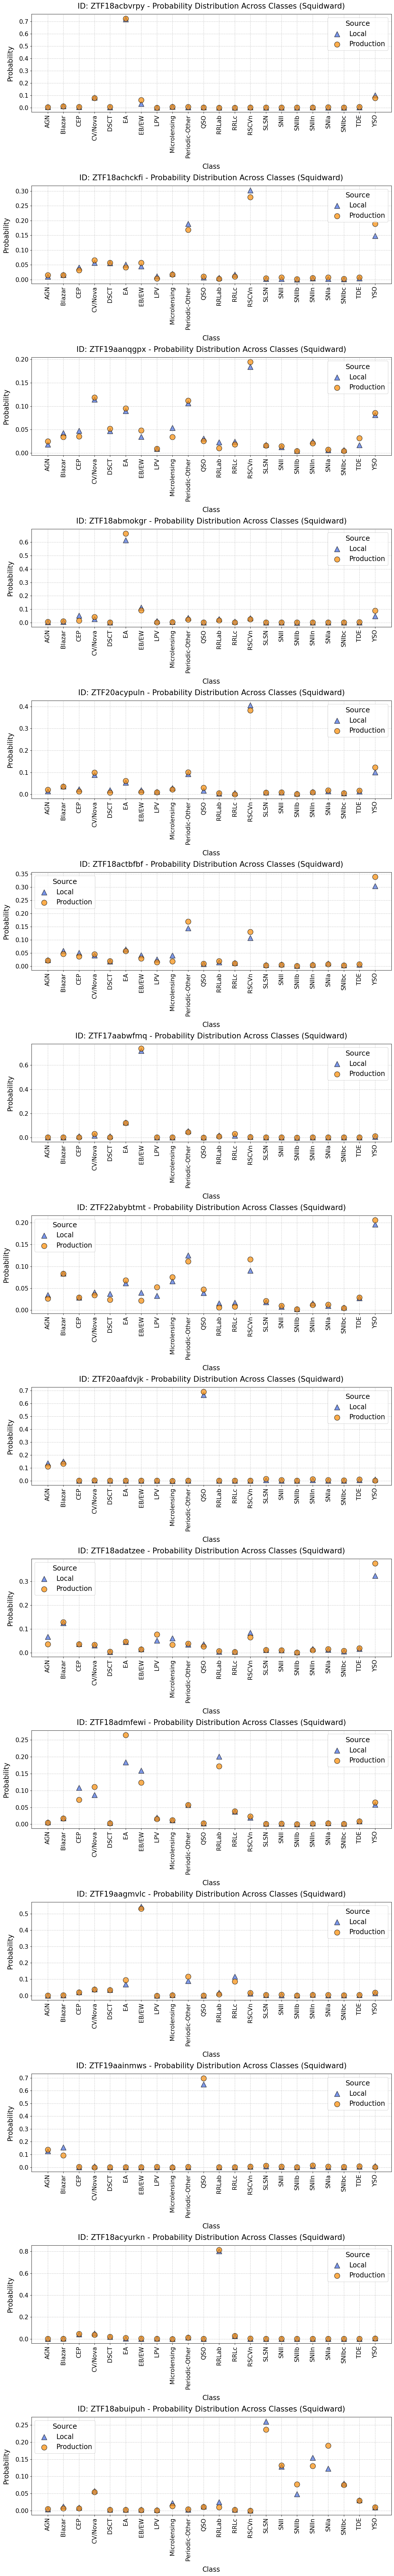

In [13]:
import matplotlib.pyplot as plt
import numpy as np

fs = 15

# Definir colores y estilos para Local y Producción
color_local = "royalblue"
color_prod = "darkorange"

unique_oids = sorted(df_hbrf['oid'].unique())
num_selected_oids = min(15, len(unique_oids))  # Asegurar que no seleccionamos más de los disponibles
selected_oids = np.random.choice(unique_oids, num_selected_oids, replace=False)
selected_oids = unique_oids[:15]

# Crear la figura con subplots dinámicos
fig, axes = plt.subplots(num_selected_oids, 1, figsize=(14, 6 * num_selected_oids))

# Si hay un solo objeto, convertir `axes` en una lista para iterar
if num_selected_oids == 1:
    axes = [axes]

# Iterar sobre los oids seleccionados
for ax, oid in zip(axes, selected_oids):
    df_oid = df_hbrf[df_hbrf['oid'] == oid]
    
    # Convertir las clases en valores numéricos
    class_labels = df_oid['class_name'].unique()
    class_to_x = {cls: i for i, cls in enumerate(class_labels)}
    df_oid = df_oid.copy()  # Create an explicit copy
    df_oid.loc[:, 'class_x'] = df_oid['class_name'].map(class_to_x)

    # Graficar datos de Local
    ax.scatter(
        df_oid['class_x'],
        df_oid['probability_local'],
        color=color_local,
        marker="^",
        s=180,
        label="Local",
        edgecolors="black",
        linewidths=1.2,
        alpha=0.7
    )

    # Graficar datos de Producción
    ax.scatter(
        df_oid['class_x'],
        df_oid['probability_prod'],
        color=color_prod,
        marker="o",
        s=180,
        label="Production",
        edgecolors="black",
        linewidths=1.2,
        alpha=0.7
    )

    # Personalizar etiquetas y diseño
    ax.set_xticks(np.arange(len(class_labels)))
    ax.set_xticklabels(class_labels, rotation=90, fontsize=fs)
    ax.tick_params(axis='y', labelsize=fs)

    ax.set_xlabel('Class', fontsize=fs+2, labelpad=14)
    ax.set_ylabel('Probability', fontsize=fs+2, labelpad=14)
    
    # Título con ID del objeto
    ax.set_title(f'ID: {oid} - Probability Distribution Across Classes (Squidward)', fontsize=fs+4, pad=14, color='black')
    
    ax.legend(fontsize=fs+2, title="Source", title_fontsize=fs+3)
    ax.grid(True, linestyle="--", alpha=0.7)

# Ajustar espacio entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Crear el gráfico de distribución de probabilidades
plt.figure(figsize=(8, 5))
plt.hist(df_local_hbrf['probability'], bins=10, alpha=0.5, label='Local', density=True)
plt.hist(df_prod_hbrf['probability'], bins=10, alpha=0.5, label='Production', density=True)

plt.xlabel('Probability')
plt.ylabel('Density')
plt.title('Distribution of Probabilities of Squidward')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()